Activation patching is the process of taking two streams of calculation, one with a 'clean' input and one with a 'corrupted' input, the corrupted input is processed in the model, but the activations resulting from the clean input are _patched_ in place. This allows for causal inference on the changes in the activations due to the corrupted input.

> Mechanism:
> - Run clean input through the model
> - Run corrupted input through the model
> - For each activation of interest, replace the corrupted input with the clean input, and calculate the difference in the output

In [6]:
import transformer_lens.patching as patching
import torch as t
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
DO_SLOW_RUNS = True
t.set_grad_enabled(False)
from IPython.display import HTML

from utils.patches import *
from utils.model import *
from utils.llc import load_model
from utils.data import prompt

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [7]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 100,
    "savefig.format": "png",
    "savefig.transparent": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "bwr",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})


In [8]:
input_size = 10
vocab = {*range(input_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=input_size,
      compiler_bos="bos",
      mlp_exactness=100)

INPUT_ENCODER = assembled_model.input_encoder
OUTPUT_ENCODER = assembled_model.output_encoder

cfg = cfg_from_tracr(assembled_model)


model_file = 'models/sort_mid_decay_l1_activation.pth'
model = HookedTransformer(cfg)
model.load_state_dict(t.load(model_file))

<All keys matched successfully>

In [9]:
resid_labels = ['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post']

sort_tok = t.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
reverse_tok = sort_tok.flip(0)
reverse_tok[0] = 9
reverse_tok[-1] = 0
all_ones_tok = t.ones(10, dtype=t.long)
all_threes = t.ones(10, dtype=t.long) * 3
all_nines_tok = t.ones(10, dtype=t.long) * 9
scrambled_tok = t.randint(0, 10, (10,))

print('Sort tokens:\t', sort_tok, 'predicted:', prompt(model, sort_tok))
print('Reverse tokens:', reverse_tok, 'predicted:', prompt(model, reverse_tok))
print('All ones tokens:', all_ones_tok, 'predicted:', prompt(model, all_ones_tok))
print('All ones tokens:', all_threes, 'predicted:', prompt(model, all_threes))
print('One three tokens:', all_nines_tok, 'predicted:', prompt(model, all_nines_tok))
print('Scrambled tokens:', scrambled_tok, 'predicted:', prompt(model, scrambled_tok))

Sort tokens:	 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) predicted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Reverse tokens: tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) predicted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
All ones tokens: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) predicted: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
All ones tokens: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) predicted: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
One three tokens: tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9]) predicted: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Scrambled tokens: tensor([4, 2, 2, 5, 7, 8, 2, 7, 9, 7]) predicted: [2, 2, 2, 4, 5, 7, 7, 7, 8, 9]


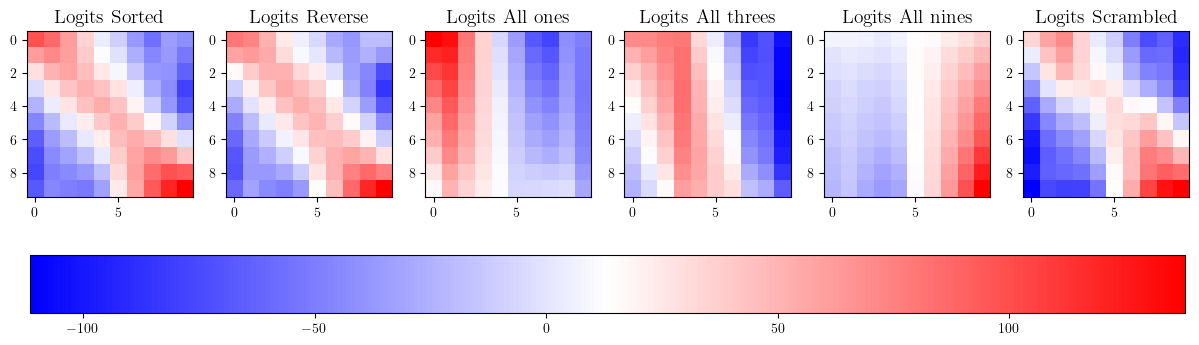

In [10]:
logits_sorted, acti_sorted = run_with_activations(model, sort_tok.unsqueeze(0))
logit_reverse, acti_reverse = run_with_activations(model, reverse_tok.unsqueeze(0))
logit_ones, acti_ones = run_with_activations(model, all_ones_tok.unsqueeze(0))
logit_three, acti_three = run_with_activations(model, all_threes.unsqueeze(0))
logit_nine, acti_nine= run_with_activations(model, all_nines_tok.unsqueeze(0))
logits_scr, acti_scr  = run_with_activations(model, scrambled_tok.unsqueeze(0))

logits = [logits_sorted, logit_reverse, logit_ones, logit_three, logit_nine, logits_scr]
logit_names = ['Sorted', 'Reverse', 'All ones', 'All threes', 'All nines', 'Scrambled']

fig, axes = plt.subplots(1, len(logits), figsize=(15, 5))
for i, (logit, ax) in enumerate(zip(logits, axes)):
    v_max = t.max(t.abs(logit)).item()
    ax.imshow(to_numpy(logit.squeeze()), vmax=v_max, vmin=-v_max)
    ax.set_title(f'Logits {logit_names[i]}')

# color bar
fig.colorbar(ax.imshow(to_numpy(logit.squeeze())), ax=axes, orientation='horizontal')
plt.show()

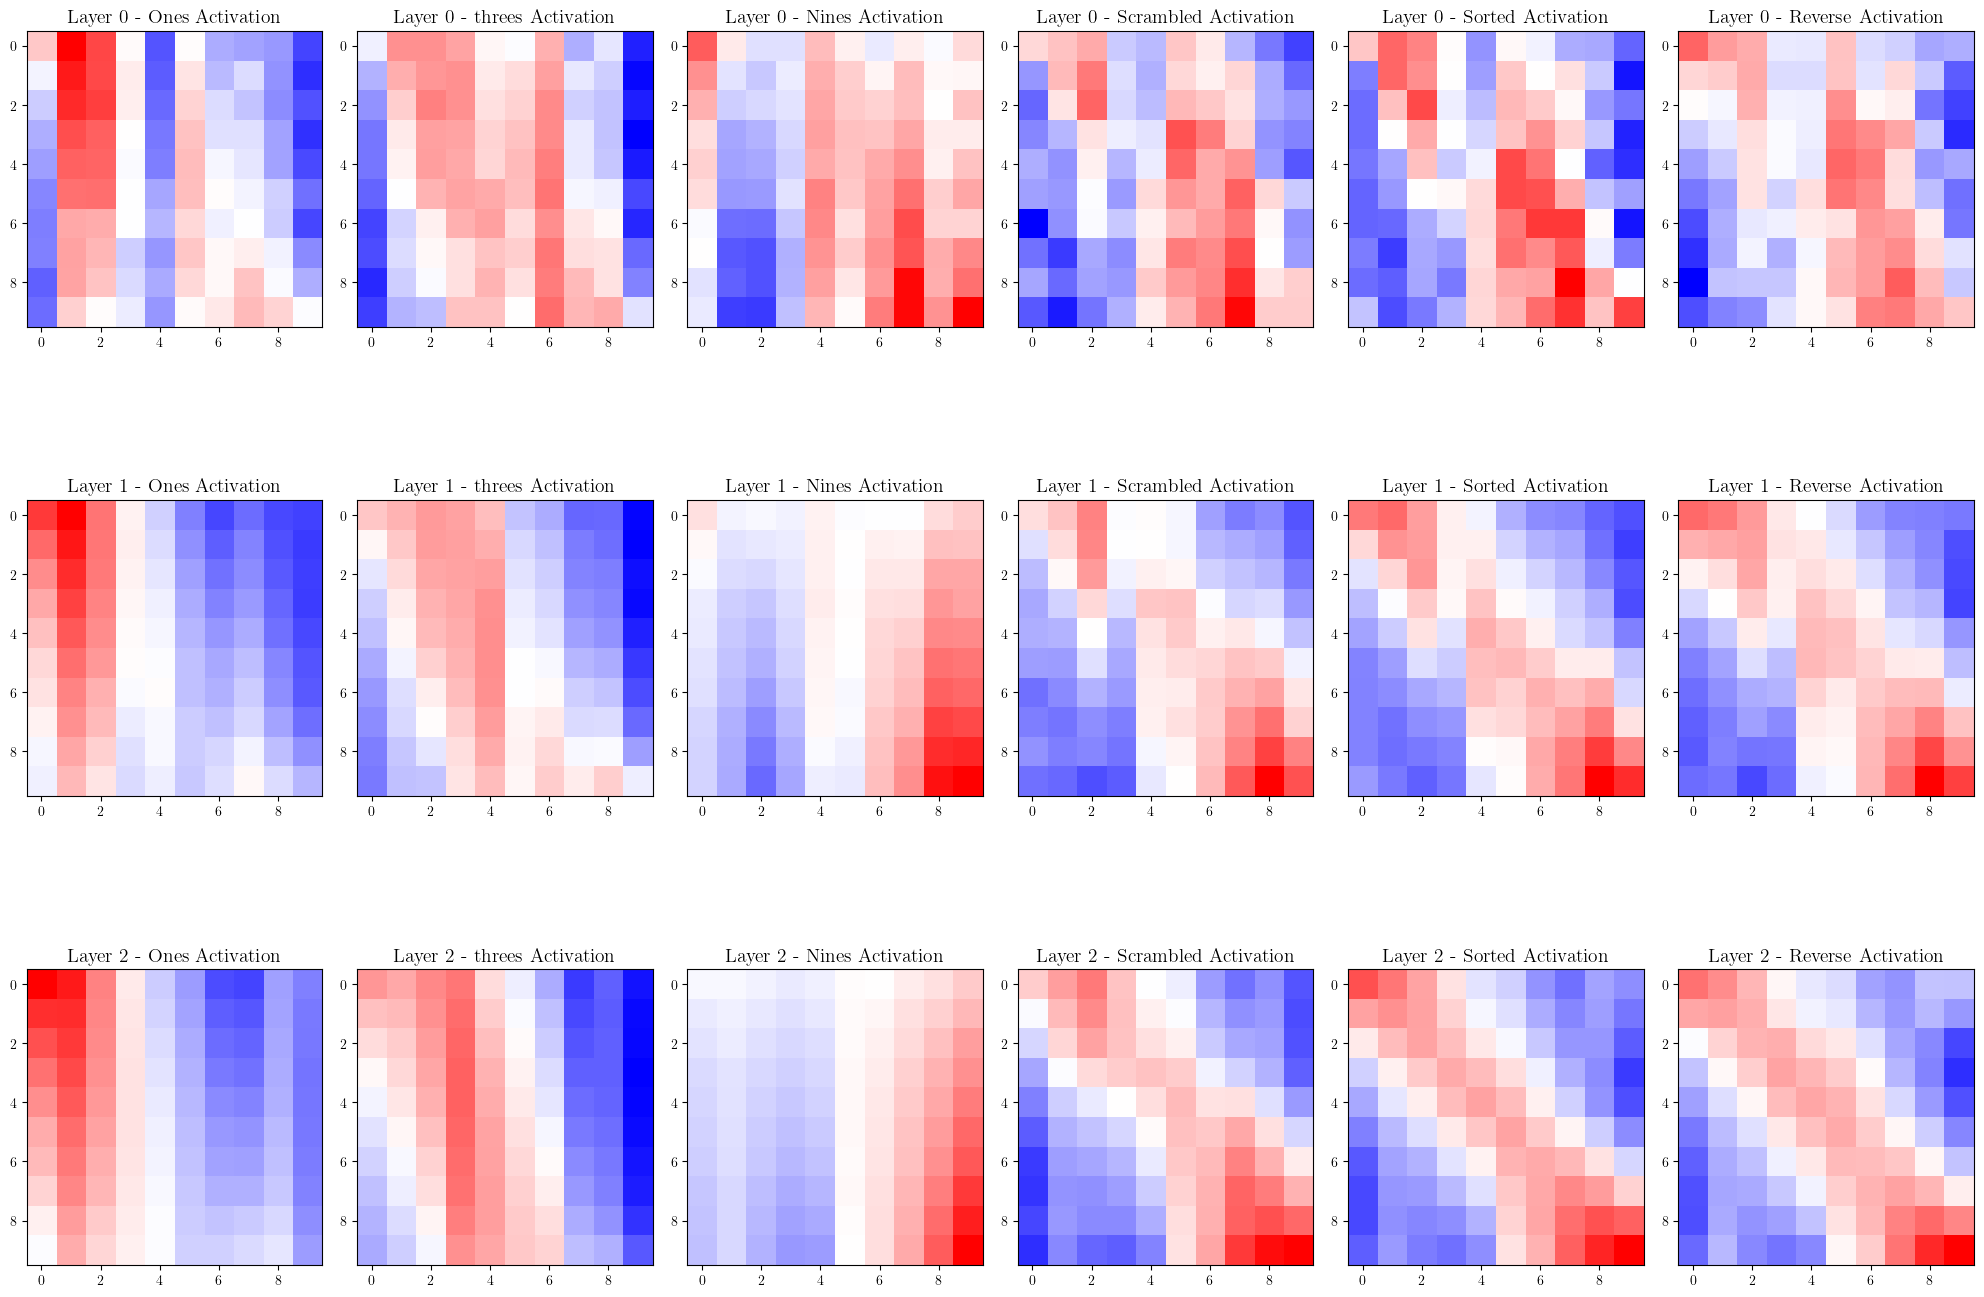

In [11]:
# inspecting the logits at every layer
layers_ones = [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_ones.items())]
layers_threes = [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_three.items())]
layers_scr= [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_scr.items())]
layers_srt= [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_sorted.items())]
layers_reverse= [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_reverse.items())]
layers_nines= [model.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_nine.items())]

activation = ['Ones', 'threes', 'Nines', 'Scrambled', 'Sorted', 'Reverse']

fig, axs = plt.subplots(3,6,figsize=(20,15))

for i, layer in enumerate(zip(layers_ones, layers_threes, layers_nines, layers_scr, layers_srt, layers_reverse)):
    for j, log in enumerate(layer):
        v_max = t.max(t.abs(log)).item()
        axs[i, j].imshow(to_numpy(log).squeeze(), vmax=v_max, vmin=-v_max)
        axs[i, j].set_title(f'Layer {i} - {activation[j]} Activation')

plt.tight_layout()
plt.show()



  0%|          | 0/30 [00:00<?, ?it/s]

/home/amir/.conda/envs/mech/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

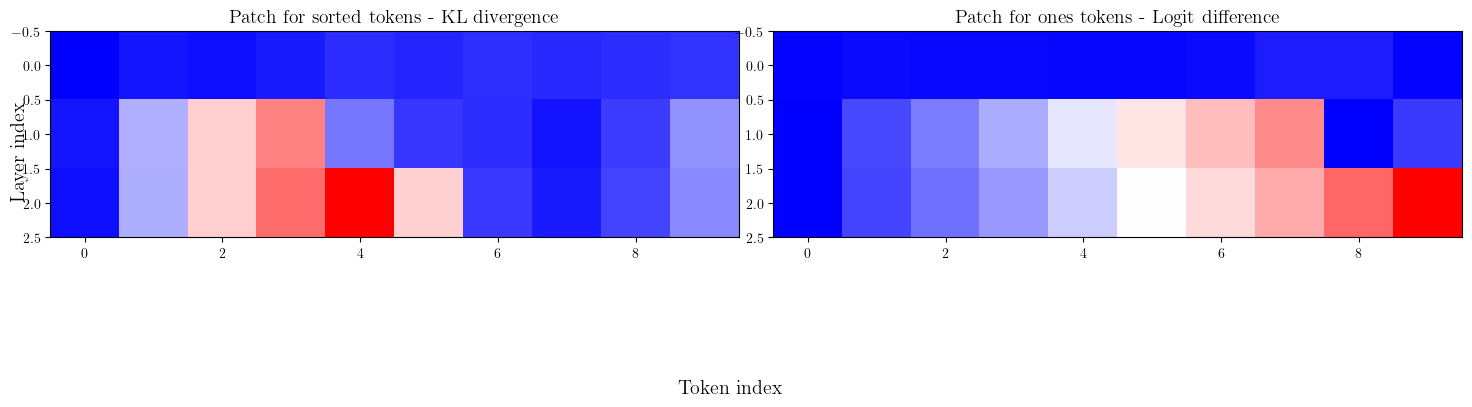

In [12]:

diff_ones = partial(logit_difference, logit_ones)
diff_sorted  = partial(logit_difference, logits_sorted)
diff_reverse = partial(logit_difference, logit_reverse)
diff_scr = partial(logit_difference, logits_scr)

div_ones = partial(kl_divergence, logit_ones)
div_sorted = partial(kl_divergence, logits_sorted)
div_reverse = partial(kl_divergence, logit_reverse)
div_scr = partial(kl_divergence, logits_scr)

# patch_ones_diff = patching.get_act_patch_resid_pre(model_tok, acti_ones, div_ones)
# patch_sort_diff = patching.get_act_patch_resid_pre(model, reverse_tok, acti_sorted, div_sorted) ## Reverse patching -> no change after layer 2, models flips input

# patch_ones_diff = patching.get_act_patch_resid_pre(model, all_nines_tok, acti_ones, div_ones)
# patch_ones_diff = patching.get_act_patch_resid_pre(model_tok, acti_ones, div_ones)

patch_ones_diff = patch(model, all_nines_tok, all_ones_tok, kl_divergence, patching.get_act_patch_resid_pre)
patch_sort_diff = patch(model, reverse_tok, all_ones_tok , kl_divergence, patching.get_act_patch_resid_pre)


fig, ax = plt.subplots(1,2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(to_numpy(patch_sort_diff).squeeze())
plt.title('Patch for sorted tokens - KL divergence')

plt.subplot(1, 2, 2)
plt.imshow(to_numpy(patch_ones_diff).squeeze())
plt.title('Patch for ones tokens - Logit difference')

# plt.subplot(2, 2, 4)
# plt.imshow(to_numpy(patch_sort_div).squeeze())
# plt.title('Patch for sorted tokens - Logit difference')

fig.supxlabel('Token index')
fig.supylabel('Layer index')
plt.tight_layout()
plt.show()


* Some kind of symmetry
    - There is a flipping mechanism?
    - Some "built-in" thing that causes low values to always have lower logits at high indices and vice versa


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

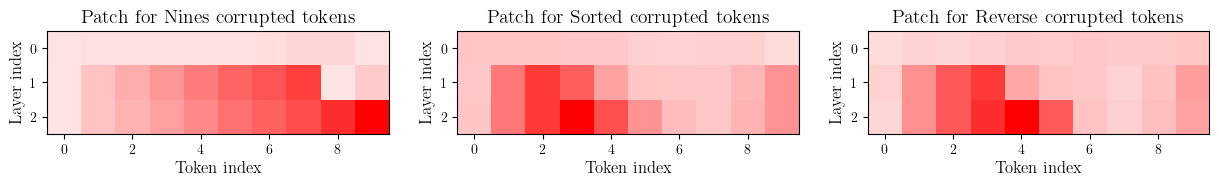

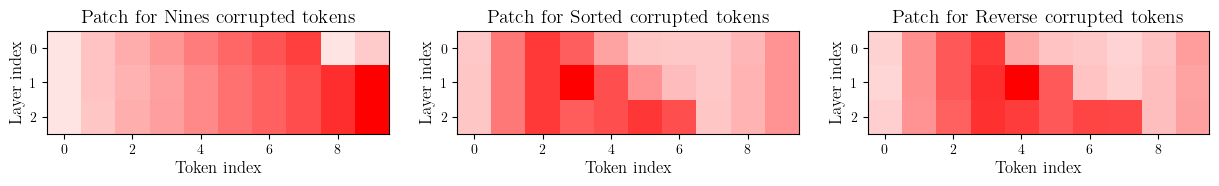

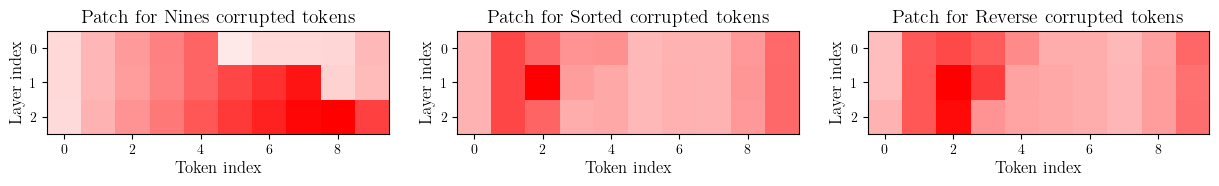

In [13]:

clean_tokens = [all_ones_tok] * 3
corrupted_tokens = [all_nines_tok, sort_tok, reverse_tok]
names = ['Nines', 'Sorted', 'Reverse']

plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_resid_pre)
plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_resid_mid)
plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_mlp_out)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

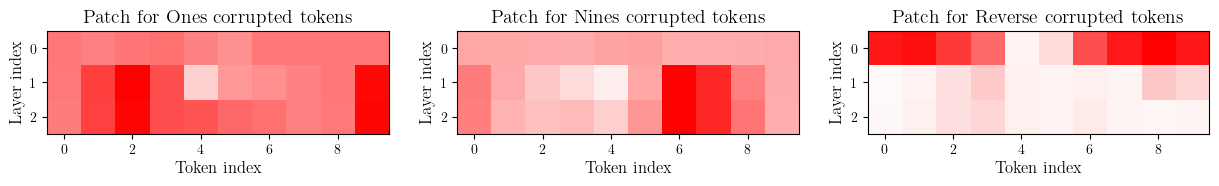

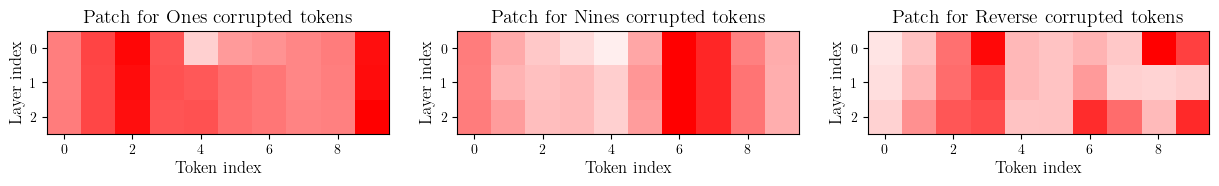

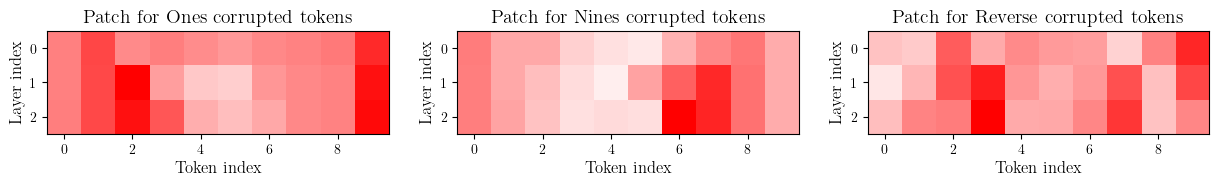

In [14]:
# Disable tqdm
clean_tokens = [sort_tok] * 3
corrupted_tokens = [all_nines_tok, all_ones_tok, reverse_tok]
names = ['Ones', 'Nines', 'Reverse']

plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_resid_pre)
plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_resid_mid)
plot_patches(corrupted_tokens, clean_tokens, model, kl_divergence, names, patching.get_act_patch_mlp_out)

# Observations
- Most of the "computation" is done in the first layer, the rest of the layers are just "refining" the output

- When patching the reverse tokens in the first resid, the output logits seem to be flipped, but doing it later does not cause this?


## Experiment 1
How does reversing the input result in reversed output?

- First see how both look in their first layer

### Answer:

- The resid-pre hook, is not the same as the embedding hook, the resid-pre hook is the hook right before the stream "splits" into resid and attn.

In [15]:
def cosine_similarity(a, b):
    return t.nn.functional.cosine_similarity(a, b, dim=-1)


def plot_all_layer(tokens):
    caches = map(partial(get_layer_1_activations, model), tokens)
    activations = list(map(lambda x: x.items(), caches))
    fig, axs = plt.subplots(16, len(tokens), figsize=(30, 70))
    for i, acts in enumerate(activations):
        for j, (label, act) in enumerate(acts):
            v_max = t.max(t.abs(act)).item()
            axs[j, i].imshow(to_numpy(act).squeeze(), vmax=v_max, vmin=-v_max)
            if j == 0:
                axs[j, i].set_title(f'{label_to_title(label)} - {tokens[i].tolist()}')
            else:
                axs[j, i].set_title(label_to_title(label))

            if label == 'logits':
                logt = axs[j,i]
                logt.set_yticks(range(0, 10, 1))
                # axs[j, i].imshow(to_numpy(act).squeeze(), vmax=v_max, vmin=-v_max, aspect='equal')
                logt.set_yticklabels(act.argmax(-1).squeeze().tolist()[::-1], color='red')
                logt.tick_params(axis='y', colors='red')
                logt.set_ylim(0, 9)
    plt.tight_layout()
    plt.show()

    return activations


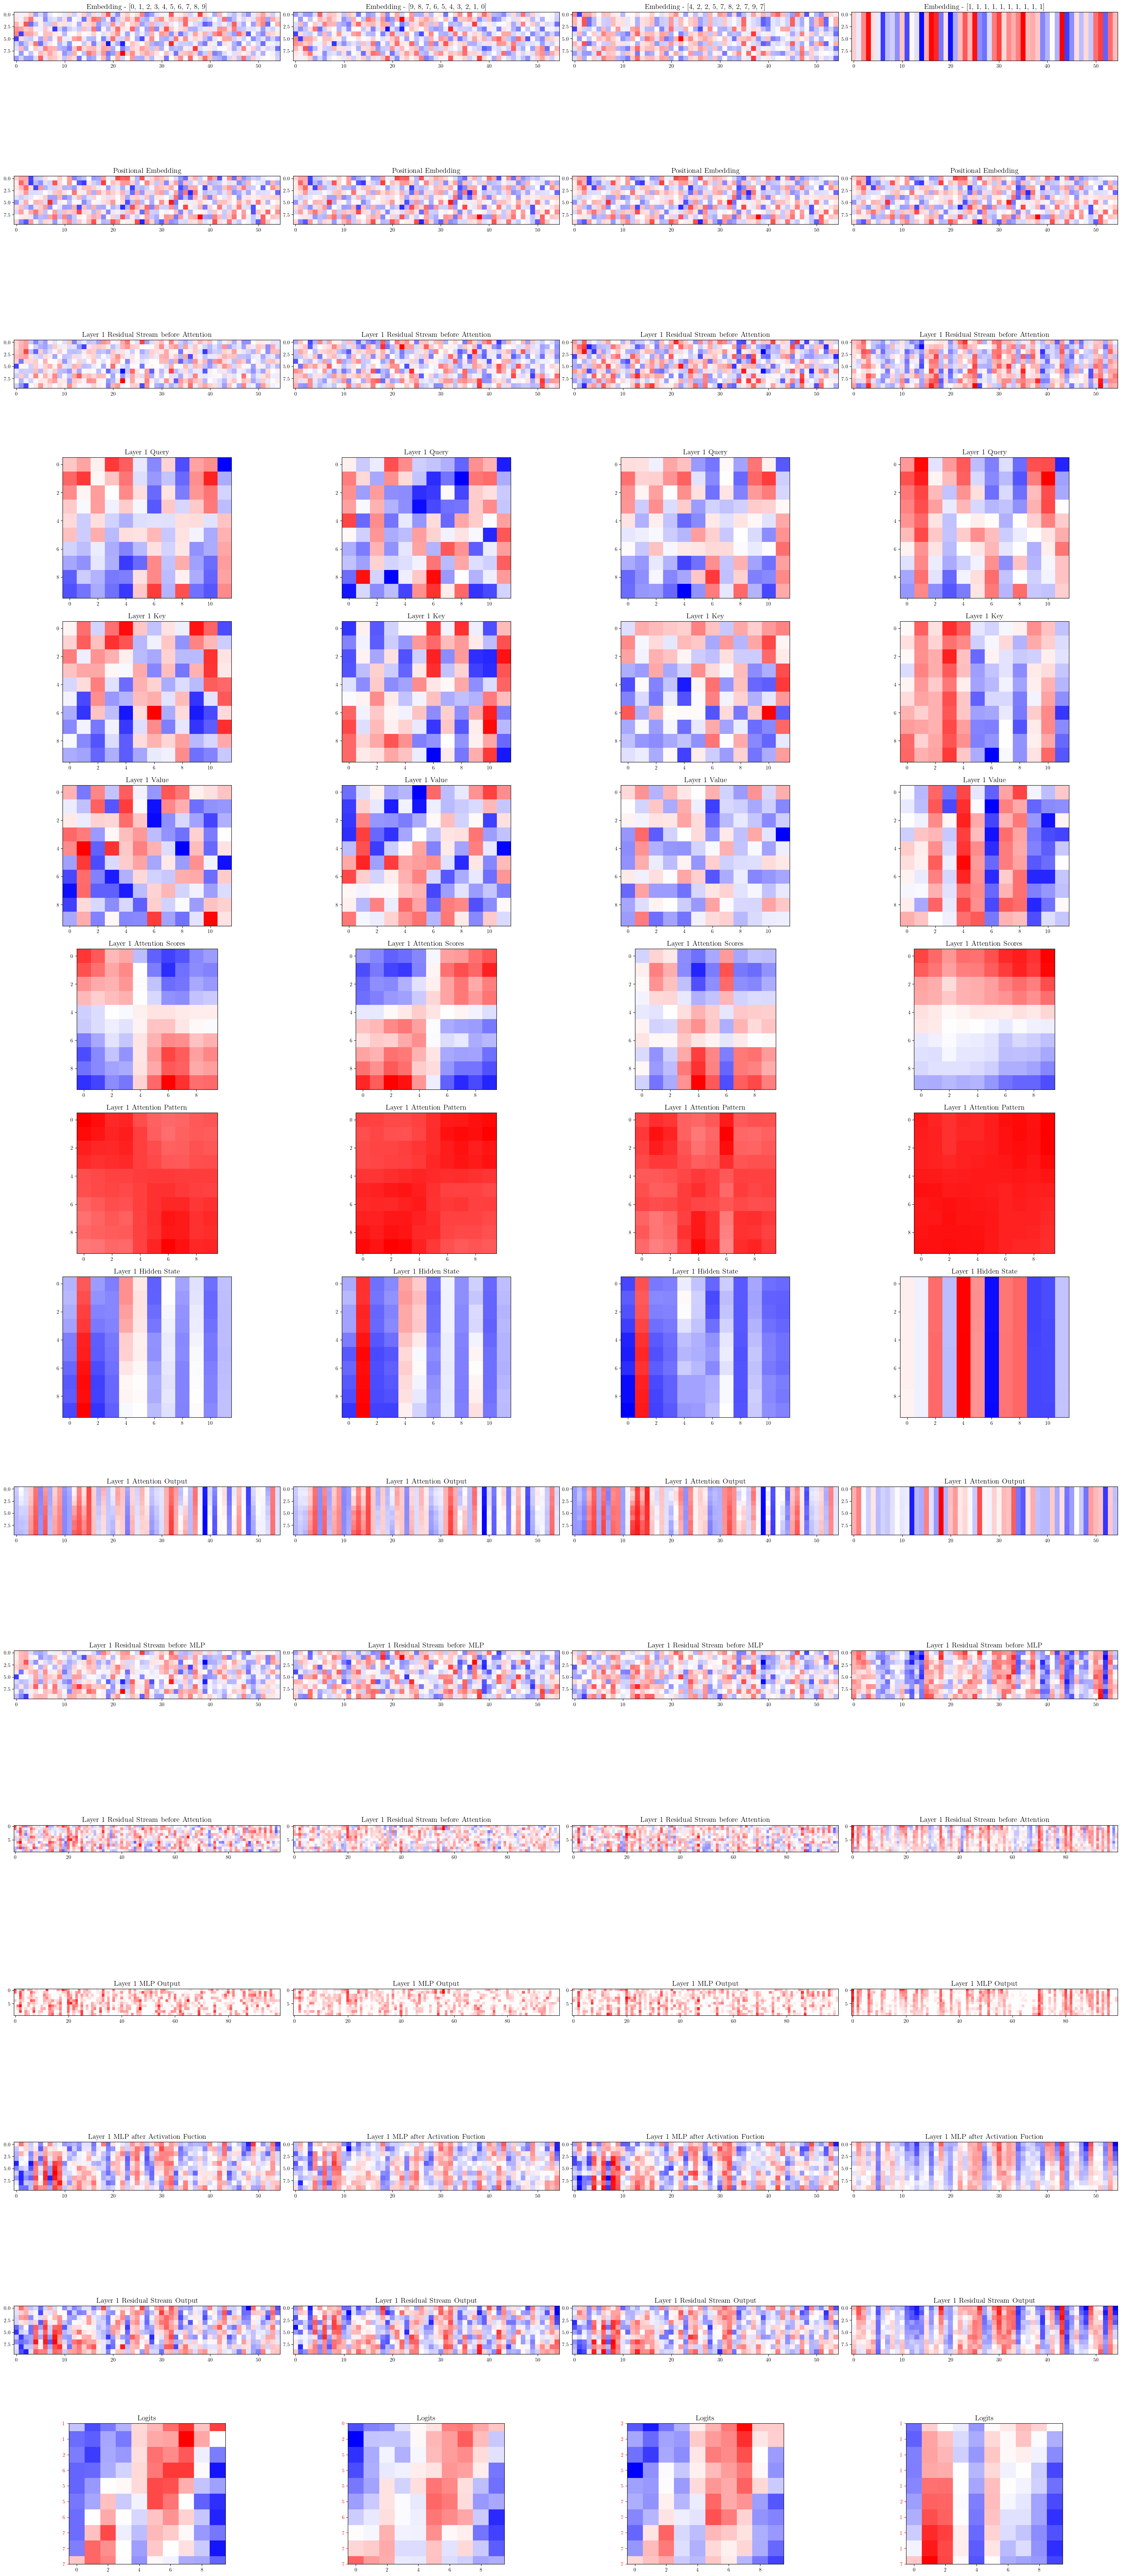

[dict_items([('hook_embed', tensor([[[ 0.0350, -0.0239,  0.0293,  0.0824, -0.1455, -0.0599, -0.1557,
           -0.0374,  0.0025,  0.0200, -0.0365,  0.0603, -0.0765,  0.0344,
            0.0736, -0.0995,  0.0595, -0.0386,  0.0957,  0.2644, -0.0597,
           -0.1764,  0.0418,  0.0849,  0.0204,  0.0601,  0.1951, -0.2055,
           -0.1529, -0.0463,  0.0264, -0.0166,  0.2649,  0.0244,  0.0299,
            0.0741, -0.0759, -0.0280,  0.3009,  0.0611, -0.0104, -0.1319,
            0.1154, -0.0142, -0.0590, -0.1033, -0.0357, -0.1015, -0.1731,
           -0.0329,  0.0761,  0.1466,  0.0551, -0.0768,  0.0253],
          [ 0.0445, -0.0197,  0.1069,  0.2228,  0.0290, -0.0209, -0.1795,
           -0.0610, -0.0456, -0.1039,  0.0565, -0.1683,  0.0080, -0.0289,
           -0.2239,  0.0755,  0.2287,  0.1962, -0.1227,  0.0279, -0.2198,
           -0.0772,  0.0593,  0.1524,  0.0648,  0.2175, -0.1044, -0.1299,
           -0.0345,  0.1198,  0.1735,  0.0382,  0.1050,  0.0747,  0.1167,
            0.2343,

In [16]:
tokens = [sort_tok, reverse_tok, scrambled_tok, all_ones_tok]
plot_all_layer(tokens)

Prompting with tokens: [0, 1, 3, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 3, 4, 5, 6, 7, 8, 9]
Prompting with tokens: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


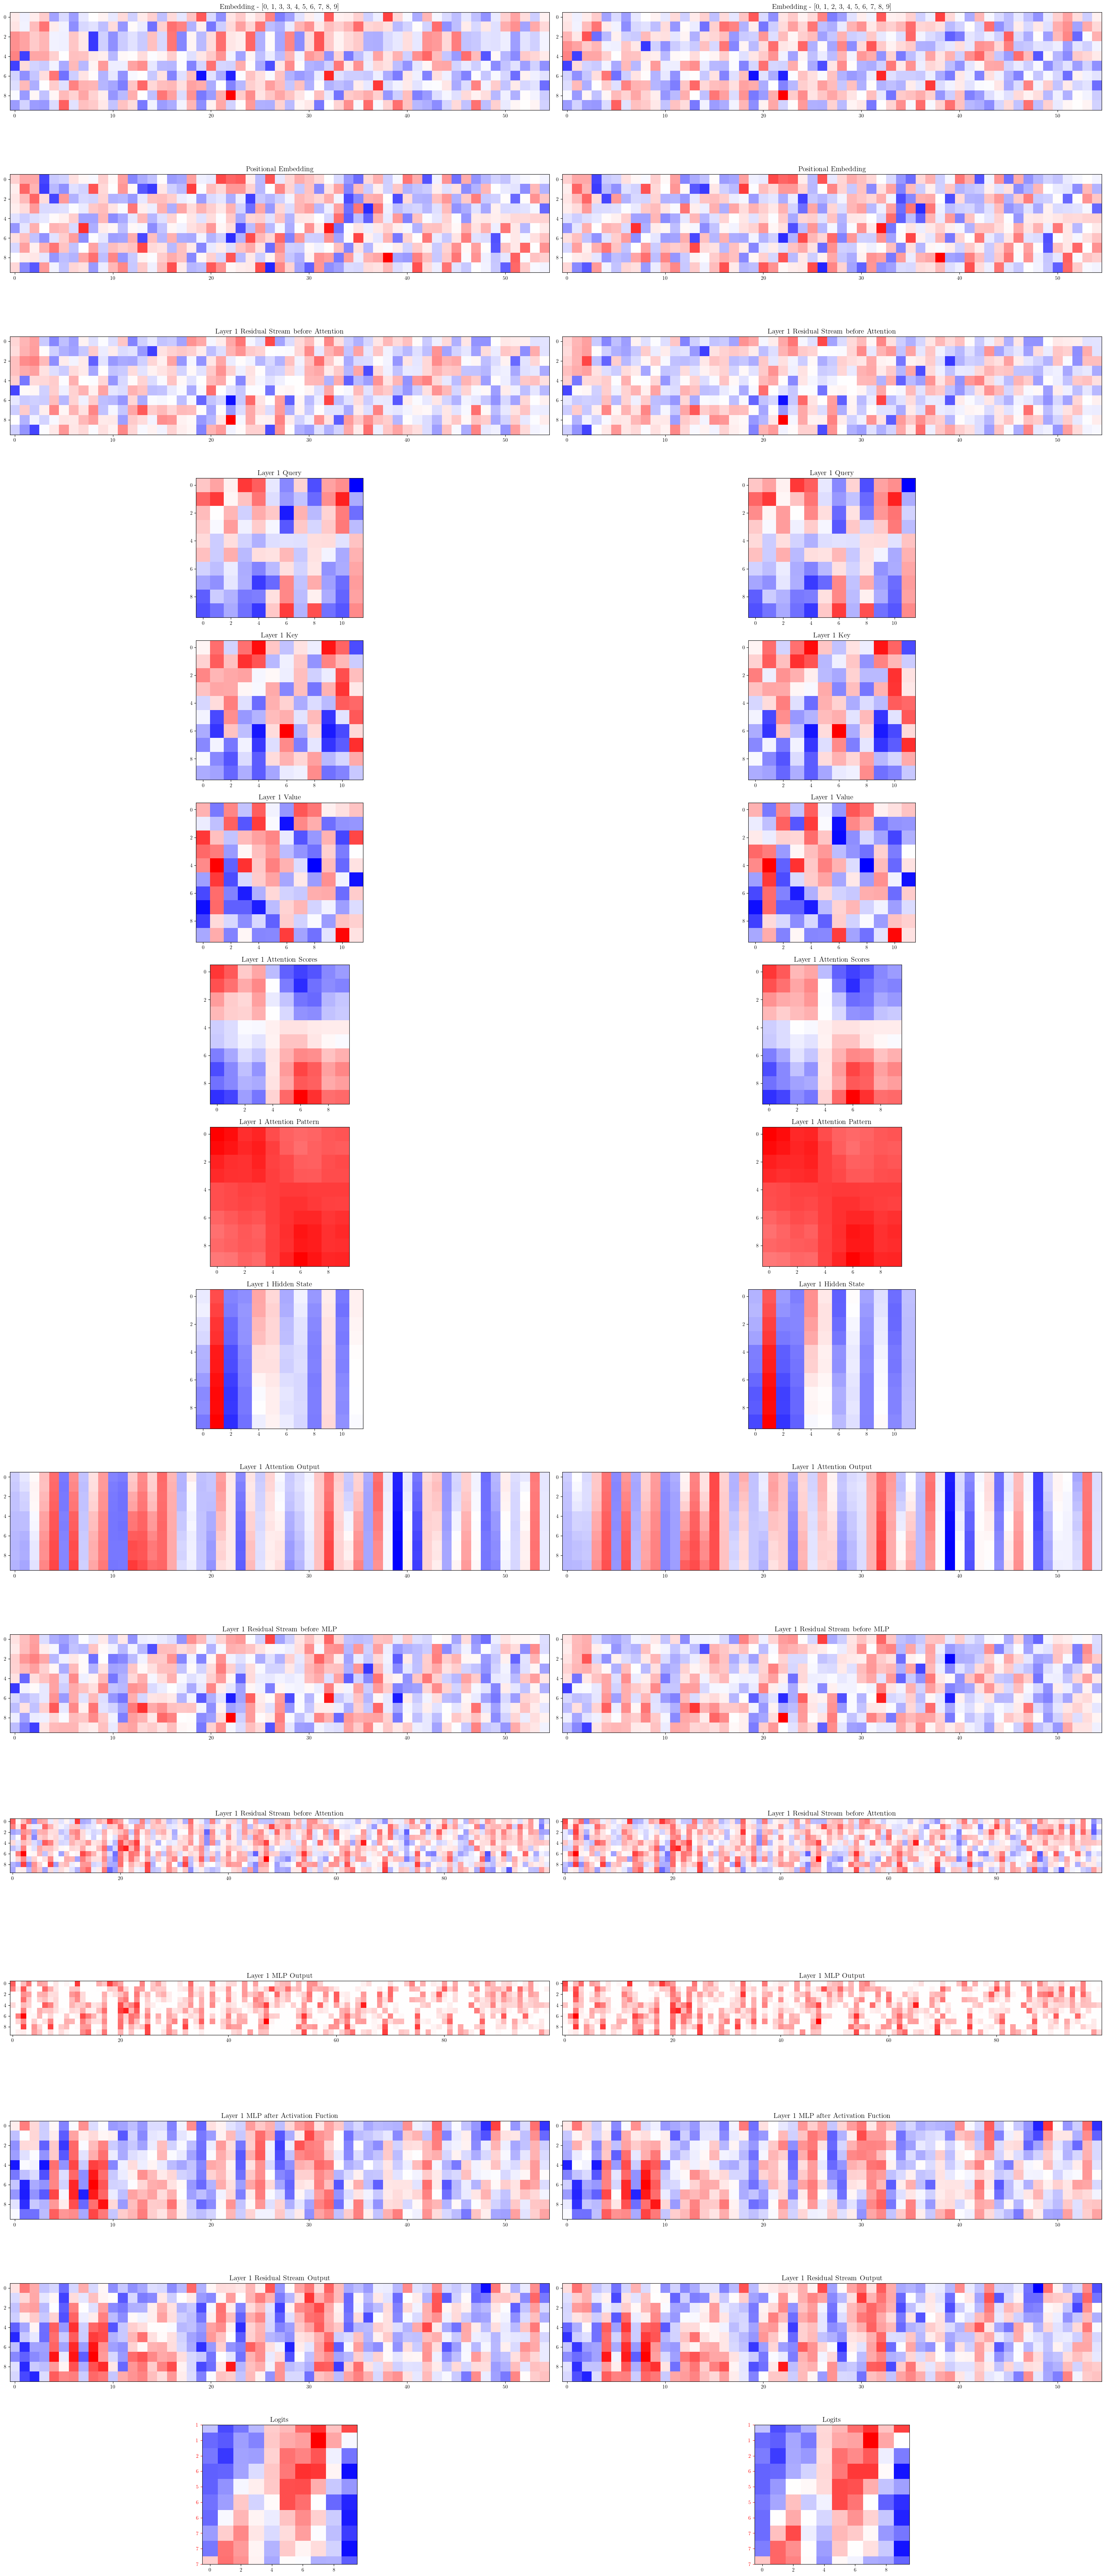

In [17]:
corrupt_sorted = sort_tok.clone()
corrupt_sorted[2] = 3
patch_tokens = [corrupt_sorted, sort_tok]

for toks in patch_tokens:
    print('Prompting with tokens:', toks.tolist())
    print(prompt(model, toks))

caches = plot_all_layer(patch_tokens)


In [18]:
for (left, right) in zip(caches[:len(caches)//2], caches[len(caches)//2:]):
    for (l, r) in zip(left, right):
        print(l[0], r[0])
        print('Cosine similarity:', cosine_similarity(l[1].squeeze(), r[1].squeeze()).tolist())
        print(f'KL divergence: {kl_divergence(l[1], r[1]).item():.3e}')
        print('\n')

hook_embed hook_embed
Cosine similarity: [0.9999999403953552, 1.0, 0.215568408370018, 1.0000001192092896, 1.0, 1.0, 1.0000001192092896, 0.9999999403953552, 1.0000001192092896, 1.0]
KL divergence: 1.069e-04


hook_pos_embed hook_pos_embed
Cosine similarity: [0.9999999403953552, 1.0, 1.0, 0.9999999403953552, 0.9999998807907104, 1.0, 0.9999998807907104, 1.0000001192092896, 1.0, 0.9999998807907104]
KL divergence: -1.084e-09


blocks.0.hook_resid_pre blocks.0.hook_resid_pre
Cosine similarity: [0.9999999403953552, 0.9999999403953552, 0.6146546602249146, 0.9999998807907104, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0]
KL divergence: 1.335e-04


blocks.0.attn.hook_q blocks.0.attn.hook_q
Cosine similarity: [1.0000001192092896, 1.0, 0.8581795692443848, 1.0, 1.0, 1.0, 0.9999998807907104, 0.9999999403953552, 1.0000001192092896, 1.0]
KL divergence: 1.018e-04


blocks.0.attn.hook_k blocks.0.attn.hook_k
Cosine similarity: [1.0000001192092896, 0.9999999403953552, 0.8638541102409363, 1.0, 1.0, 0.999999

/home/amir/.conda/envs/mech/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


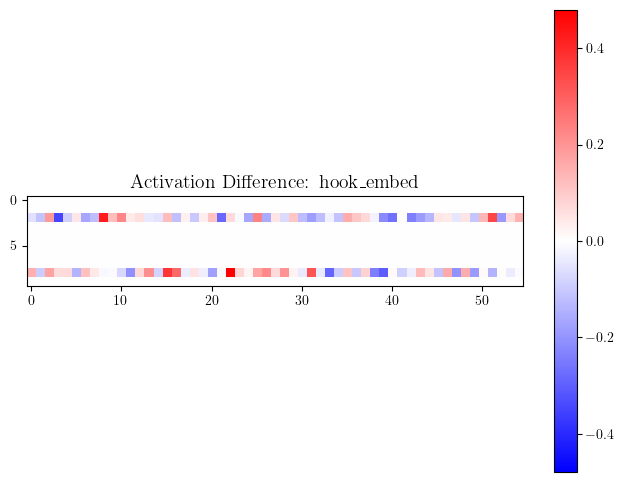

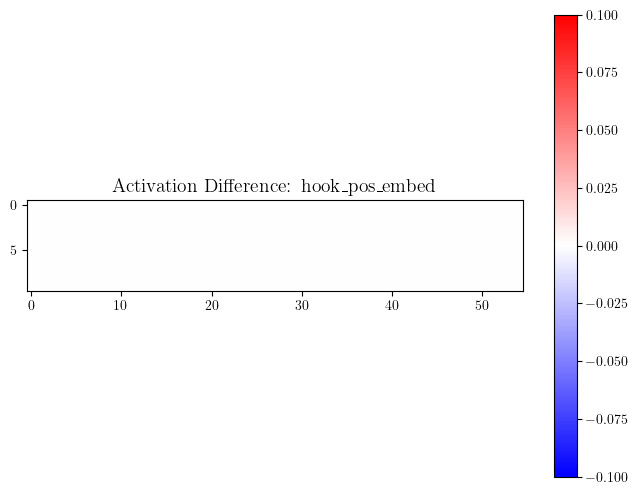

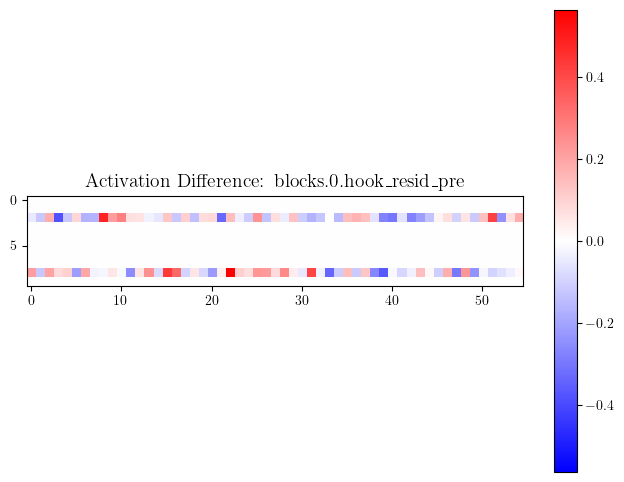

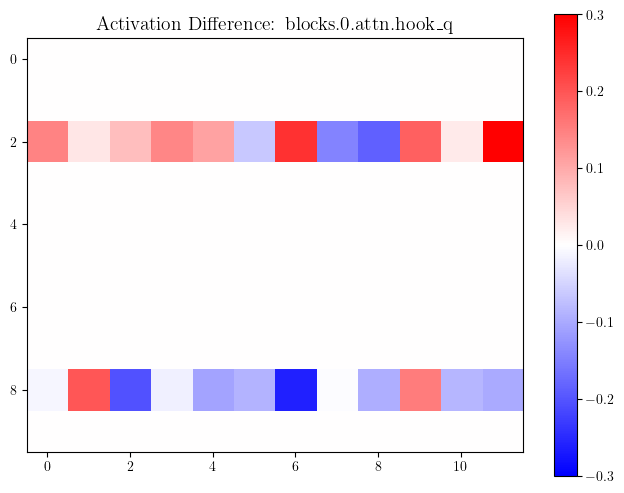

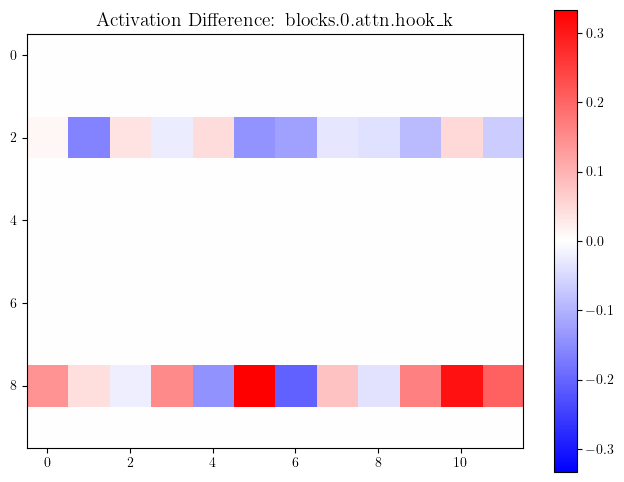

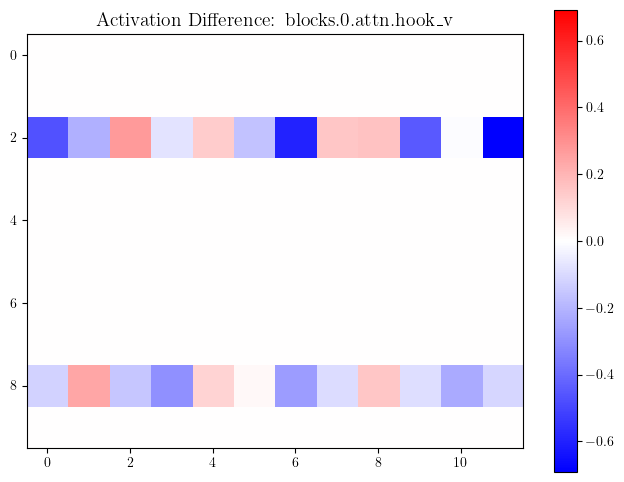

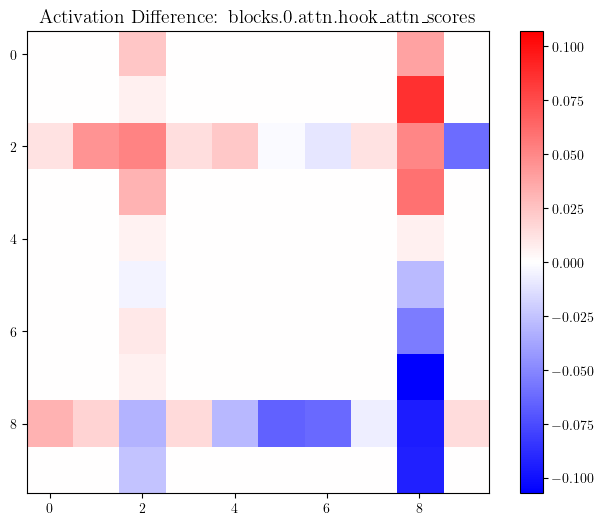

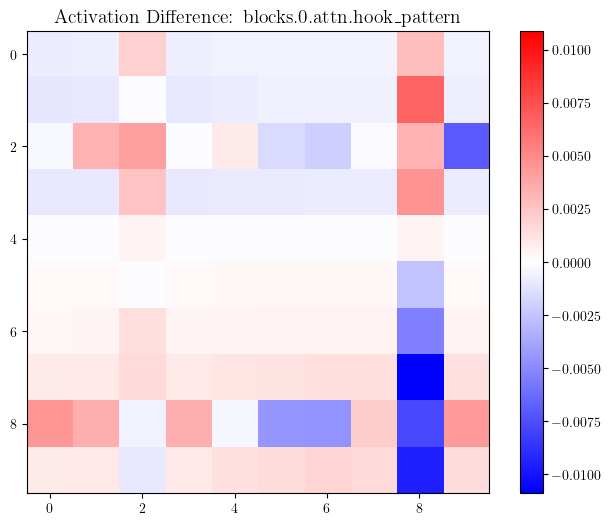

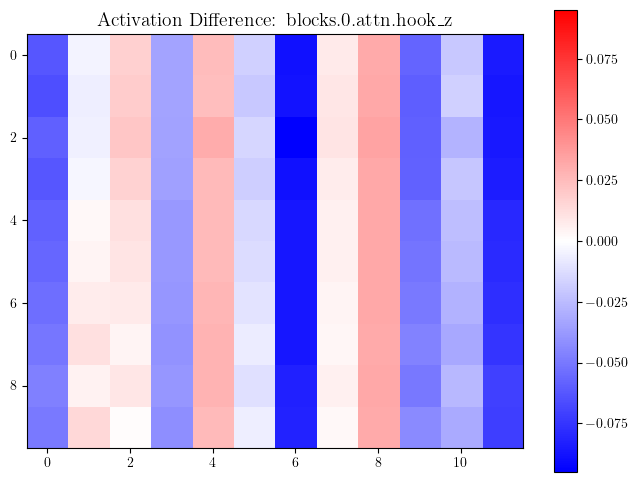

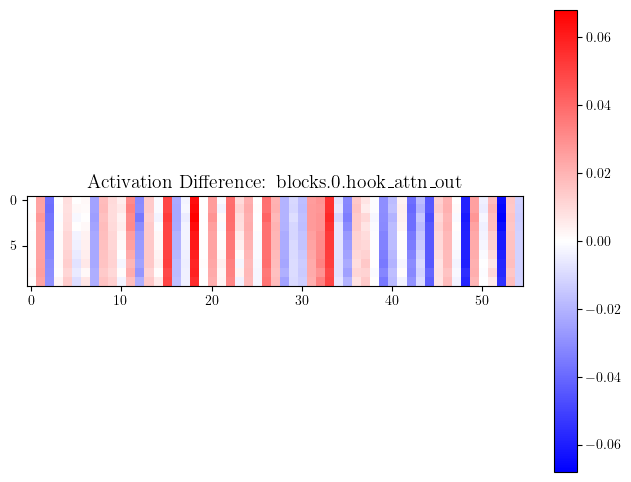

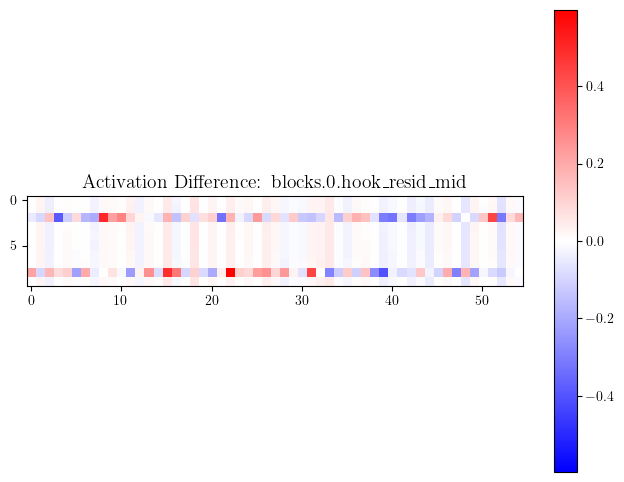

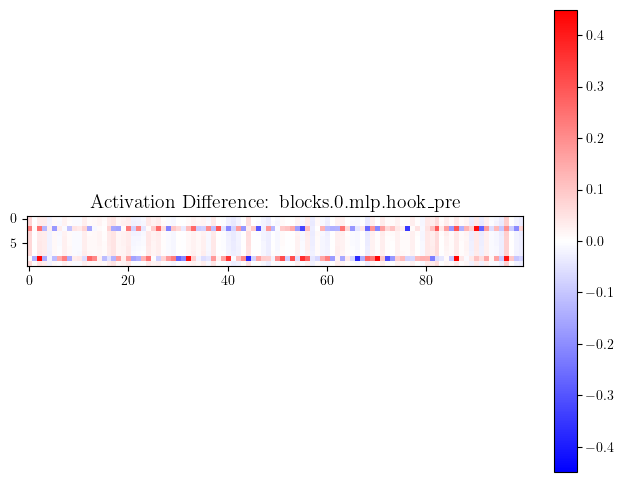

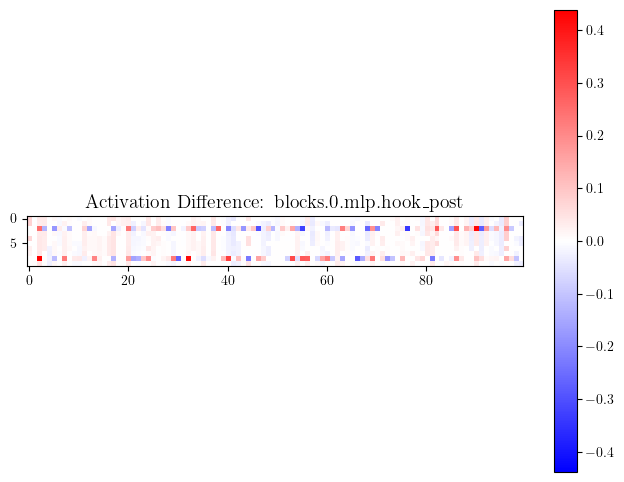

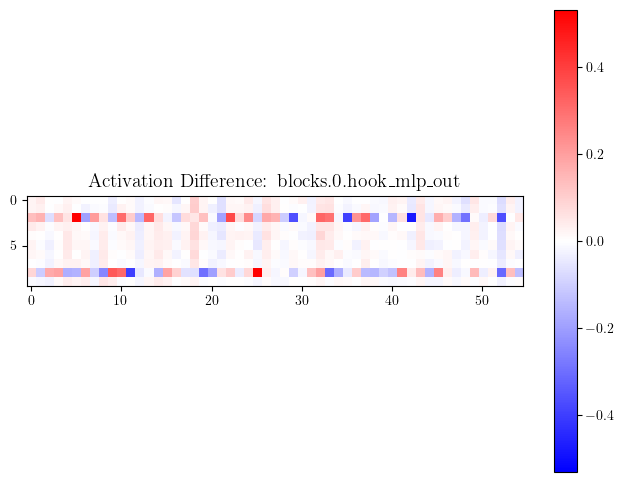

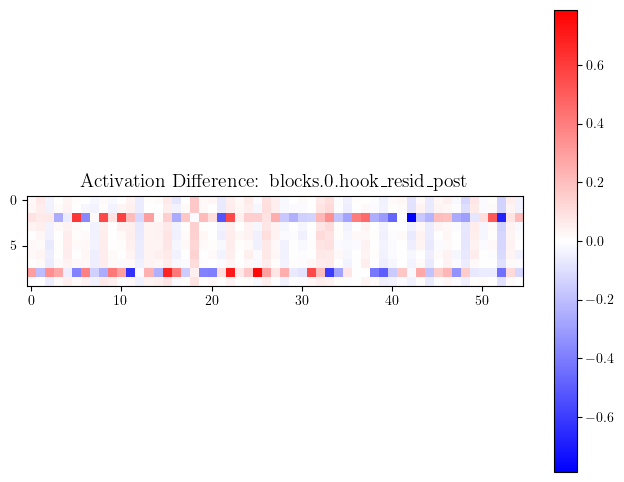

In [19]:
def plot_diff_activations(clean_tok, corrupted_tok):
    _, clean_acts = model.run_with_cache(clean_tok)
    _, corrupted_acts = model.run_with_cache(corrupted_tok)
    
    for label, act in clean_acts.items():
        if '0' in label or 'embed' in label:
            clean_act = clean_acts[label]
            corrupted_act = corrupted_acts[label]
            
            diff = corrupted_act - clean_act
            
            # Visualize the activation difference
            v_max = t.max(t.abs(diff)).item()
            plt.imshow(to_numpy(diff).squeeze(), vmax=v_max, vmin=-v_max)
            plt.colorbar()
            plt.title(f"Activation Difference: {label}")
            plt.show()

patch_tokens[0][8] = 9
# Patch activations for different token types
plot_diff_activations(*patch_tokens)

In [30]:
vis_attn(run_with_activations(model, patch_tokens[0])[1], list(map(lambda x: str(x.item()), patch_tokens[0])), 'Patch token')

# QK and OV circiuts
Code adapted from: https://colab.research.google.com/drive/1N4iPEyBVuctveCA0Zre92SpfgH6nmHXY?usp=sharing#scrollTo=QIWMjF0JyEve&uniqifier=1


In [21]:
from einops import einsum

def calculate_qk_attn_heatmap(model, keypos=-1, querypos=-1):
    attn = model.blocks[0].attn
    all_token_embeddings = model.embed(range(12))
    positional_embeddings = model.pos_embed(all_token_embeddings)

    token_embeddings_at_keypos = all_token_embeddings + positional_embeddings[:,keypos,:] if keypos > -1 else all_token_embeddings
    token_embeddings_at_querypos = all_token_embeddings + positional_embeddings[:,querypos,:] if querypos > -1 else all_token_embeddings

    embeddings_key = einsum(
        attn.W_K.squeeze(),
        token_embeddings_at_keypos.unsqueeze(0),
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head"
    )

    embeddings_query = einsum(
        attn.W_Q.squeeze(),
        token_embeddings_at_querypos.unsqueeze(0),
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head"
    )


                            
    qk_circuit_attn_heatmap = einsum(
        embeddings_query, 
        embeddings_key,
        "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k" 
        ).detach().cpu().numpy()

    return qk_circuit_attn_heatmap

def avg_qk_heatmap(model, keypositions, querypos=-1):
  heatmaps = []
  
  for keypos in keypositions:
    heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos))

  qk_circuit_attn_heatmap = np.mean(heatmaps, axis=0)
  return qk_circuit_attn_heatmap

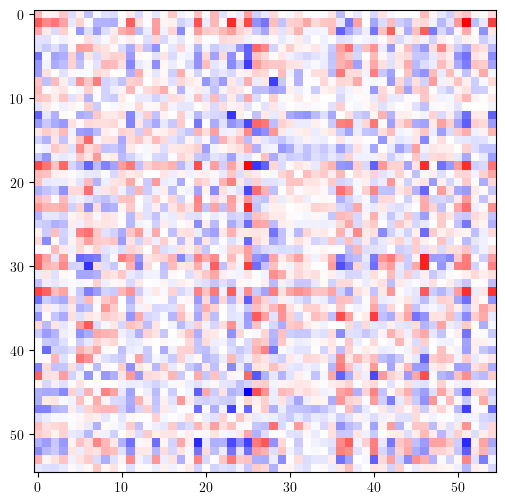

In [22]:
qk_ciruit = avg_qk_heatmap(model, [0, 1])

plt.imshow(qk_ciruit)

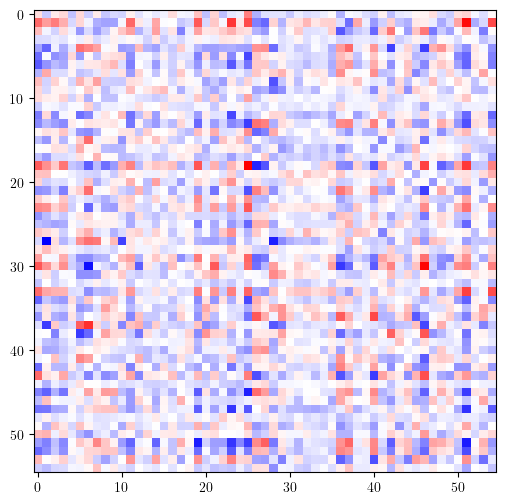

In [23]:
qk_ciruit = avg_qk_heatmap(model, [2, 3])

plt.imshow(qk_ciruit)

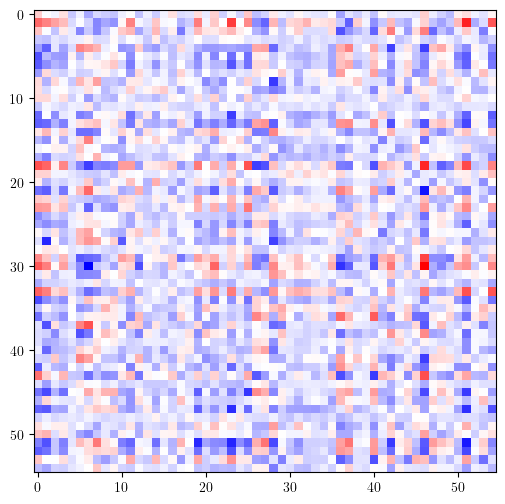

In [24]:
qk_ciruit = avg_qk_heatmap(model, [8, 9])

plt.imshow(qk_ciruit)

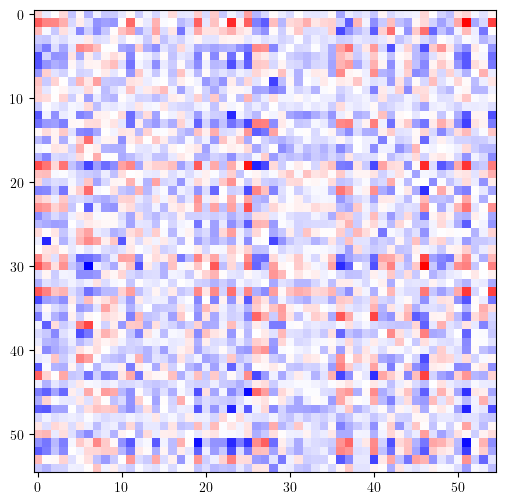

In [26]:
qk_ciruit = avg_qk_heatmap(model, [*range(10)])

plt.imshow(qk_ciruit)

In [ ]:
def plot_ov_heatmap(model, pos=-1):
    attn = model.blocks[0].attn
    all_token_embeddings = model.embed(range(12))

    token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

    embeddings_value = einsum(
    attn.W_V.squeeze(),
    token_embeddings_at_pos.unsqueeze(0),
    "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head"
    )
  
    embeddings_out = einsum(
        attn.W_O,
        embeddings_value,
        "n_heads d_vocab d_model1, n_heads d_model1 d_model2 -> n_heads d_vocab d_model2"
        )
  
    ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach()
    return to_numpy(ov_circuit_attn_heatmap)

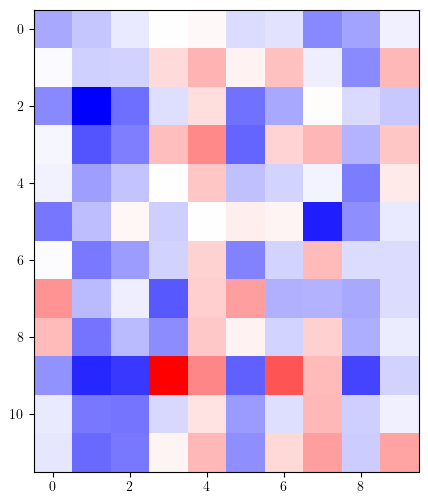

In [ ]:
ov_ciruit = plot_ov_heatmap(model, 9)

plt.imshow(ov_ciruit.squeeze())

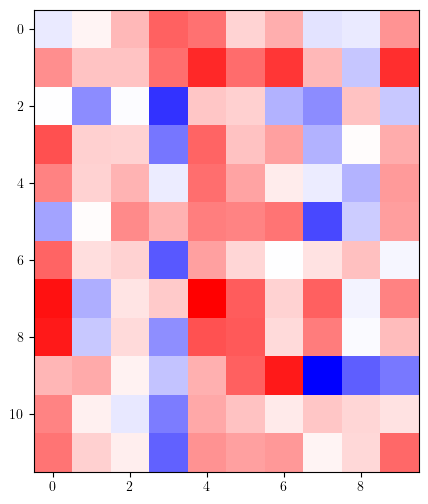

In [ ]:
ov_ciruit = plot_ov_heatmap(model, 0)

plt.imshow(ov_ciruit.squeeze())

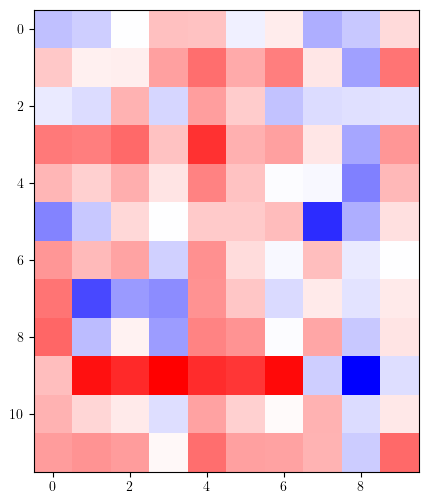

In [ ]:
ov_ciruit = plot_ov_heatmap(model, 5)

plt.imshow(ov_ciruit.squeeze())

We can see that at the 9th 

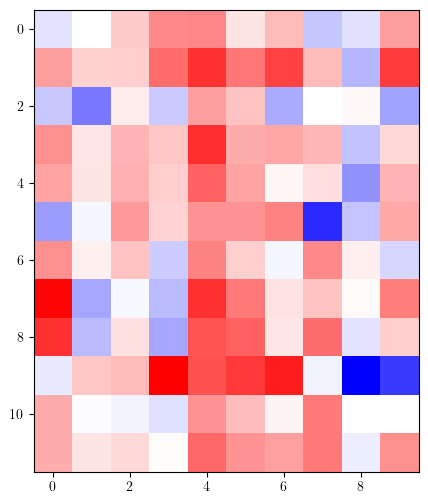

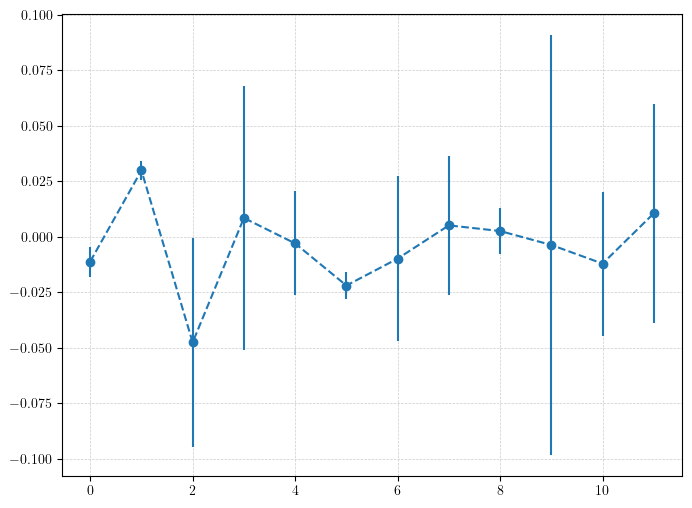

In [ ]:
avg_ov_headmap = np.mean([plot_ov_heatmap(model, i) for i in range(10)], axis=0)

plt.imshow(avg_ov_headmap.squeeze())
plt.show()

# plot mean over each token position, with standard deviation
avg_ov_headmap = np.mean([plot_ov_heatmap(model, i) for i in range(10)], axis=0)
std_ov_headmap = np.std([plot_ov_heatmap(model, i) for i in range(10)], axis=0)

fig, ax = plt.subplots(1, 1)
ax.errorbar(range(12), avg_ov_headmap.squeeze().mean(1), yerr=std_ov_headmap.squeeze().mean(1), fmt='o--')
plt.grid()
plt.show()


# Investigating model checkpoints

In [ ]:
model_ck = HookedTransformer(cfg)
model_file = 'checkpoints/sort_mid_decay_l1_activation.pth_50'
model_ck.load_state_dict(t.load(model_file))

<All keys matched successfully>

In [ ]:
print('Sort tokens:\t', sort_tok, 'predicted:', prompt(model_ck, sort_tok))
print('Reverse tokens:', reverse_tok, 'predicted:', prompt(model_ck, reverse_tok))
print('All ones tokens:', all_ones_tok, 'predicted:', prompt(model_ck, all_ones_tok))
print('All ones tokens:', all_threes, 'predicted:', prompt(model_ck, all_threes))
print('One three tokens:', all_nines_tok, 'predicted:', prompt(model_ck, all_nines_tok))
print('Scrambled tokens:', scrambled_tok, 'predicted:', prompt(model_ck, scrambled_tok))

Sort tokens:	 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) predicted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Reverse tokens: tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) predicted: [0, 2, 2, 3, 4, 5, 6, 8, 8, 9]
All ones tokens: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) predicted: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
All ones tokens: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) predicted: [0, 0, 3, 3, 3, 3, 3, 3, 3, 5]
One three tokens: tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9]) predicted: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Scrambled tokens: tensor([2, 6, 1, 2, 4, 4, 2, 4, 5, 7]) predicted: [1, 1, 2, 2, 4, 4, 5, 5, 6, 7]


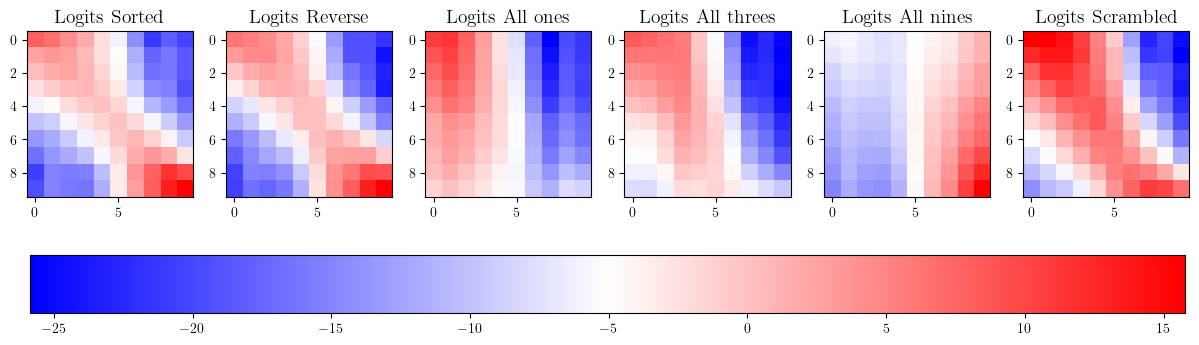

In [ ]:
logits_sorted, acti_sorted = run_with_activations(model_ck, sort_tok.unsqueeze(0))
logit_reverse, acti_reverse = run_with_activations(model_ck, reverse_tok.unsqueeze(0))
logit_ones, acti_ones = run_with_activations(model_ck, all_ones_tok.unsqueeze(0))
logit_three, acti_three = run_with_activations(model_ck, all_threes.unsqueeze(0))
logit_nine, acti_nine= run_with_activations(model_ck, all_nines_tok.unsqueeze(0))
logits_scr, acti_scr  = run_with_activations(model_ck, scrambled_tok.unsqueeze(0))

logits = [logits_sorted, logit_reverse, logit_ones, logit_three, logit_nine, logits_scr]
logit_names = ['Sorted', 'Reverse', 'All ones', 'All threes', 'All nines', 'Scrambled']

fig, axes = plt.subplots(1, len(logits), figsize=(15, 5))
for i, (logit, ax) in enumerate(zip(logits, axes)):
    v_max = t.max(t.abs(logit)).item()
    ax.imshow(to_numpy(logit.squeeze()), vmax=v_max, vmin=-v_max)
    ax.set_title(f'Logits {logit_names[i]}')

# color bar
fig.colorbar(ax.imshow(to_numpy(logit.squeeze())), ax=axes, orientation='horizontal')
plt.show()

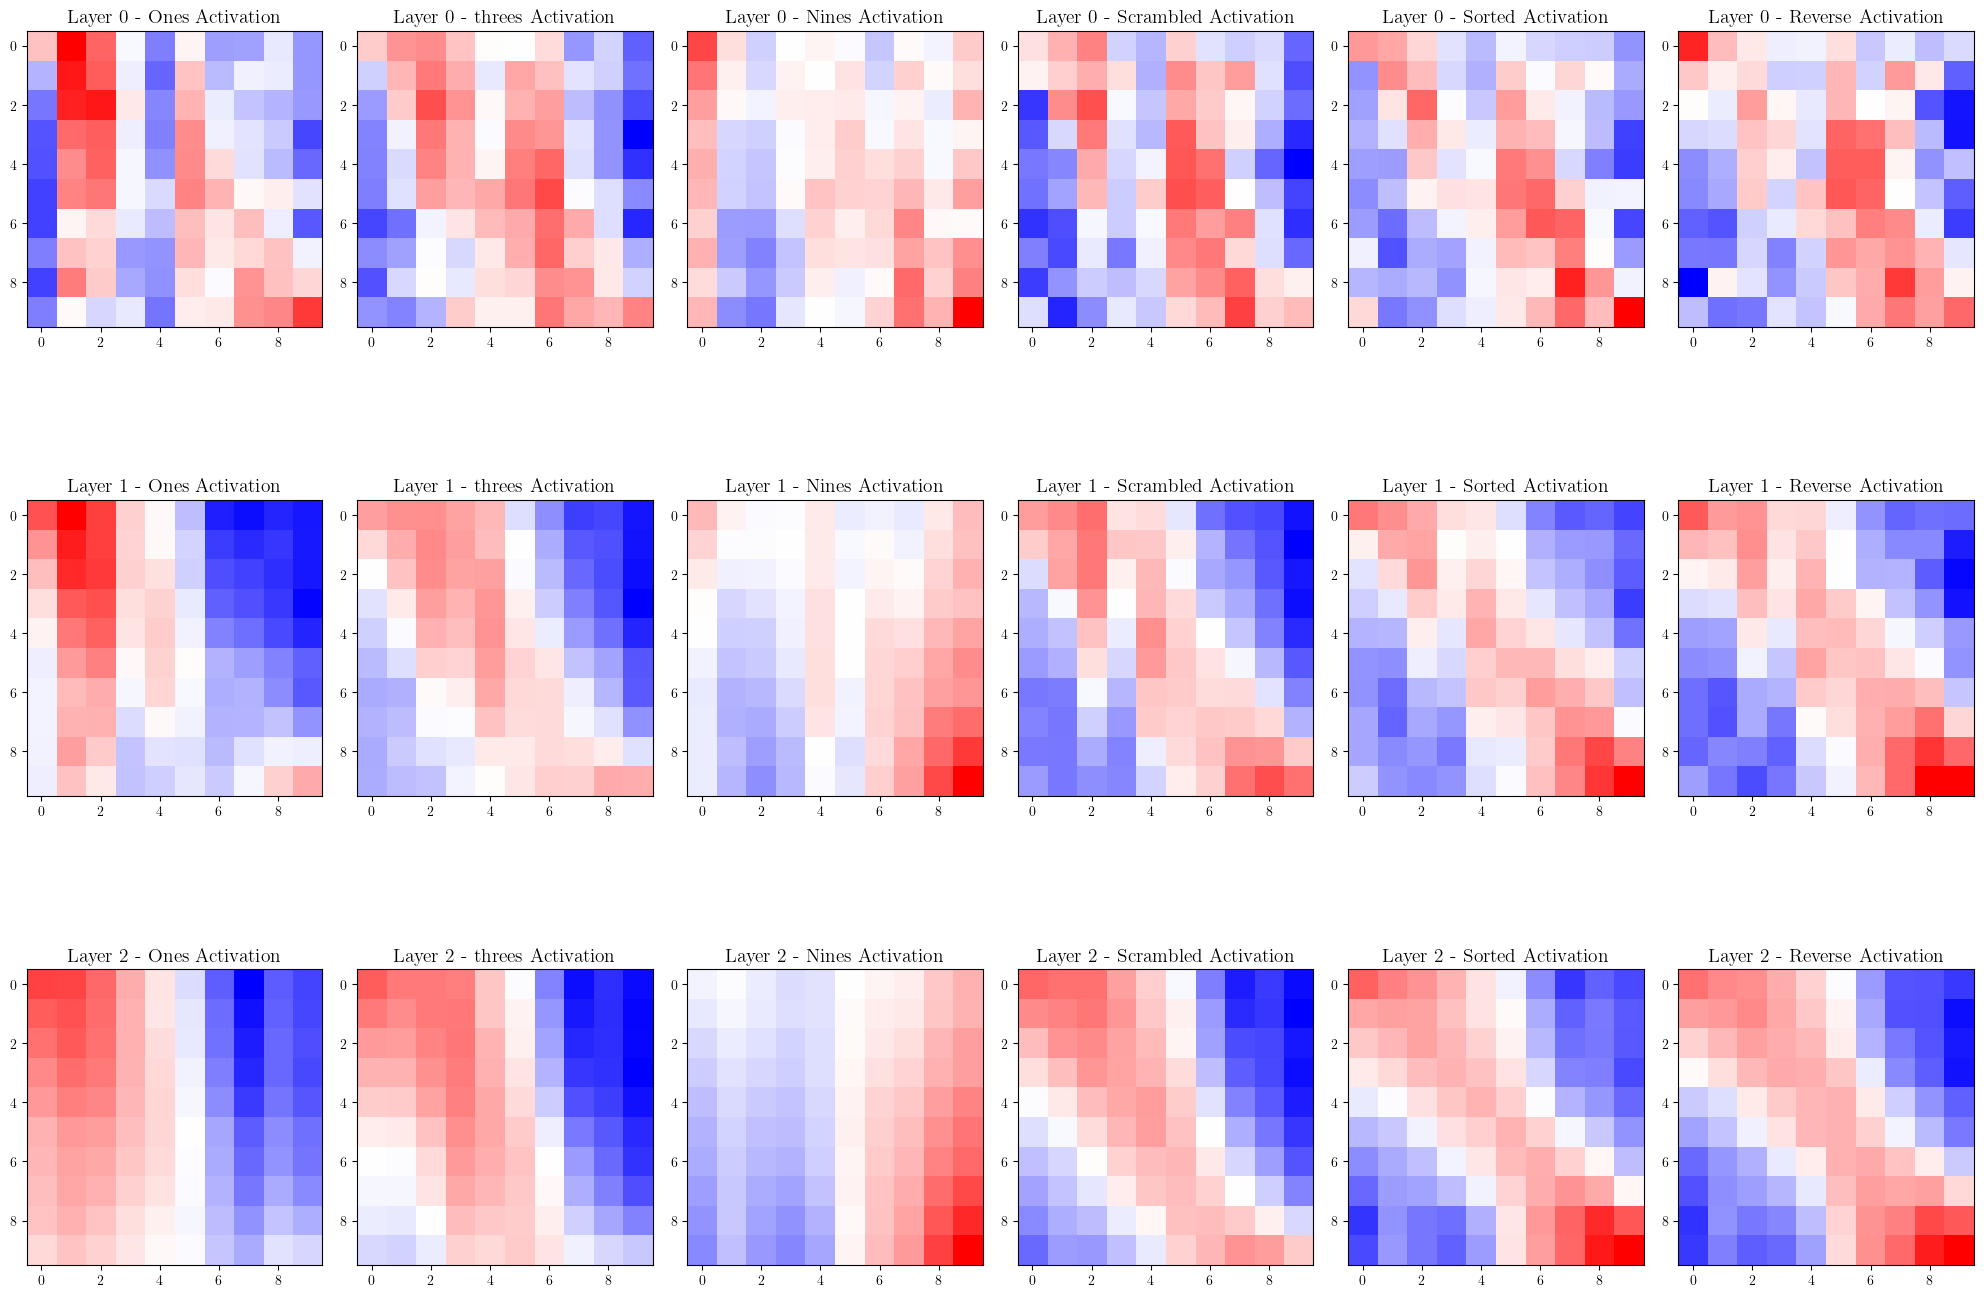

In [ ]:
layers_ones = [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_ones.items())]
layers_threes = [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_three.items())]
layers_scr= [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_scr.items())]
layers_srt= [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_sorted.items())]
layers_reverse = [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_reverse.items())]
layers_nines = [model_ck.unembed(layer) for _,layer in filter(lambda x: x[0] in resid_labels, acti_nine.items())]

activation = ['Ones', 'threes', 'Nines', 'Scrambled', 'Sorted', 'Reverse']

fig, axs = plt.subplots(3,6,figsize=(20,15))

for i, layer in enumerate(zip(layers_ones, layers_threes, layers_nines, layers_scr, layers_srt, layers_reverse)):
    for j, log in enumerate(layer):
        v_max = t.max(t.abs(log)).item()
        axs[i, j].imshow(to_numpy(log).squeeze(), vmax=v_max, vmin=-v_max)
        axs[i, j].set_title(f'Layer {i} - {activation[j]} Activation')

plt.tight_layout()
plt.show()